In [1]:
import robot_plotter as rp
import models_functions as mf
import traj
import numpy as np
import matplotlib.pyplot as plt
import robot_sim as sim
import sim_helper_funcs as hfunc

## Script for running many simulations of a particular trajectory
Run many simulations with set random seeds, for use with ANEES purposes. 

This one is for Luft et al's implementation of the CL algorithm

In [2]:
# generate reference trajectory
dt = 0.01

pos1, y_IMU1_base, xa1 = hfunc.path1_slow(dt)
pos2, y_IMU2_base, xa2 = hfunc.path2_slow(dt)
pos3, y_IMU3_base, xa3 = hfunc.path3_slow(dt)

pos_len = pos1.shape[1] # Assumes that all paths have the same length

# Generate anchors position:
xanc1, xanc2 = hfunc.anc_setup1()

In [3]:
R_b = 0.0009
R_r = 0.001
R_w = 0.0002
R_a = 0.004

Q=np.diag([0.1, 8.0, 8.0, 0.000001, 0.00001, 0.00001])
R=np.diag([R_b, R_r, R_w, R_a, R_a]) # approx vaules from datasheets
P=np.diag([0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0004,0.01,0.01]) # Initialize with system noise for bias

anchor1 = sim.Anchor(x0=xanc1)
anchor2 = sim.Anchor(x0=xanc2)


In [4]:
list_seeds = [1061, 1, 19001, 7871871, 2289]
#1061, 1, 19001, 7871871, 2289
seeds_num = len(list_seeds)
x_logL1 = np.zeros((mf.STATE_LEN, pos_len, seeds_num))
P_logL1 = np.zeros((mf.STATE_LEN, mf.STATE_LEN, pos_len, seeds_num))
x_logL2 = np.zeros((mf.STATE_LEN, pos_len, seeds_num))
P_logL2 = np.zeros((mf.STATE_LEN, mf.STATE_LEN, pos_len, seeds_num))
x_logL3 = np.zeros((mf.STATE_LEN, pos_len, seeds_num))
P_logL3 = np.zeros((mf.STATE_LEN, mf.STATE_LEN, pos_len, seeds_num))

for j in range(len(list_seeds)):
    print("seed: " + str(list_seeds[j]))
    bias_vec = np.array([[0.07],[0.2],[0.2]])
    timu1 = y_IMU1_base.copy()
    timu2 = y_IMU2_base.copy()
    timu3 = y_IMU3_base.copy()

    np.random.seed(list_seeds[j])
    y_IMU1 = traj.gen_noise(timu1, dt=1, sigma=np.diag([R_w, R_a, R_a]), bias=bias_vec)
    y_IMU2 = traj.gen_noise(timu2, dt=1, sigma=np.diag([R_w, R_a, R_a]), bias=bias_vec)
    y_IMU3 = traj.gen_noise(timu3, dt=1, sigma=np.diag([R_w, R_a, R_a]), bias=bias_vec)

    # Run LUFT algorithm
    robotL1 = sim.robot_luft(x0=xa1, path=pos1, imu=y_IMU1, dt=dt, Q=Q, R=R, P=P, id=111)
    robotL2 = sim.robot_luft(x0=xa2, path=pos2, imu=y_IMU2, dt=dt, Q=Q, R=R, P=P, id=222)
    robotL3 = sim.robot_luft(x0=xa3, path=pos3, imu=y_IMU3, dt=dt, Q=Q, R=R, P=P, id=333)

    for i in range(pos_len-1):
        robotL1.predict(imu_correct=True)
        robotL2.predict(imu_correct=True)
        robotL3.predict(imu_correct=True)
        # Set up a measurement pattern similar to the used communication protocol
        # First module:
        if (i > 0 and i % 100 == 0):
            print("robot1 update at " + str(i))
            hfunc.updateAllLuft(robotL1, [anchor1], [robotL2], sr=R_r, sb=R_b)
        # Second module:
        if (i > 0 and (i+33) % 100 == 0):
            print("robot2 update at " + str(i))
            hfunc.updateAllLuft(robotL2, [], [robotL1, robotL3], sr=R_r, sb=R_b)
        # Third module:
        if (i > 0 and (i+66) % 100 == 0):
            print("robot3 update at " + str(i))
            hfunc.updateAllLuft(robotL3, [anchor2], [robotL2], sr=R_r, sb=R_b)
    
    # Save estimates and covariances:
    x_logL1[:,:,j] = robotL1.x_log
    P_logL1[:,:,:,j] = robotL1.P_log
    x_logL2[:,:,j] = robotL2.x_log
    P_logL2[:,:,:,j] = robotL2.P_log
    x_logL3[:,:,j] = robotL3.x_log
    P_logL3[:,:,:,j] = robotL3.P_log


seed: 1061
robot3 update at 34
Adding new robot: 333
Adding new robot: 222
robot2 update at 67
Adding new robot: 222
Adding new robot: 111
robot1 update at 100
robot3 update at 134
robot2 update at 167
robot1 update at 200
robot3 update at 234
robot2 update at 267
robot1 update at 300
robot3 update at 334
robot2 update at 367
robot1 update at 400
robot3 update at 434
robot2 update at 467
robot1 update at 500
robot3 update at 534
robot2 update at 567
robot1 update at 600
robot3 update at 634
robot2 update at 667
robot1 update at 700
robot3 update at 734
robot2 update at 767
robot1 update at 800
robot3 update at 834
robot2 update at 867
robot1 update at 900
robot3 update at 934
robot2 update at 967
robot1 update at 1000
robot3 update at 1034
robot2 update at 1067
robot1 update at 1100
robot3 update at 1134
robot2 update at 1167
robot1 update at 1200
robot3 update at 1234
robot2 update at 1267
robot1 update at 1300
robot3 update at 1334
robot2 update at 1367
robot1 update at 1400
robot3 u

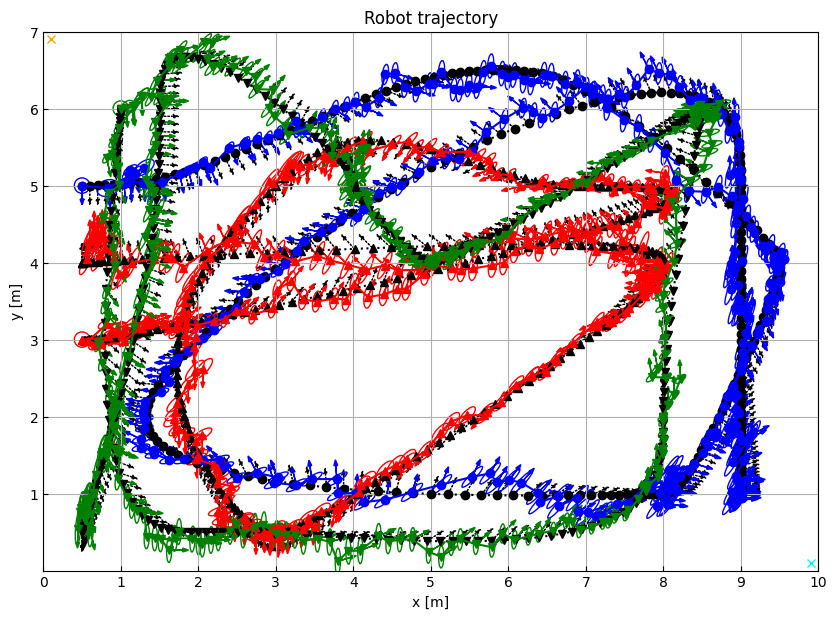

In [14]:
# Plot the choosen simulation:
s_idx = 0

# Plot ground truth
fig, ax = rp.setup_plot()
rp.plot_position(ax, pos1[:,::200], color='black', marker='o', linestyle=':')
rp.plot_position(ax, pos2[:,::200], color='black', marker='^', linestyle=':')
rp.plot_position(ax, pos3[:,::200], color='black', marker='v', linestyle=':')

# Plot states of robots:
rp.plot_position2(ax, x_logL1[:,::200,s_idx], P_logL1[:,:,::200,s_idx], color='blue', marker='o')
rp.plot_position2(ax, x_logL2[:,::200,s_idx], P_logL2[:,:,::200,s_idx], color='red', marker='^')
rp.plot_position2(ax, x_logL3[:,::200,s_idx], P_logL3[:,:,::200,s_idx], color='green', marker='v')

anchor1.draw_position(ax, color='orange')
anchor2.draw_position(ax, color='cyan')

#ax.legend(['Robot 1 reference', 'Robot 2 reference', 'Robot 3 reference', 'Robot 1 path', 'Robot 2 path', 'Robot 3 path'])

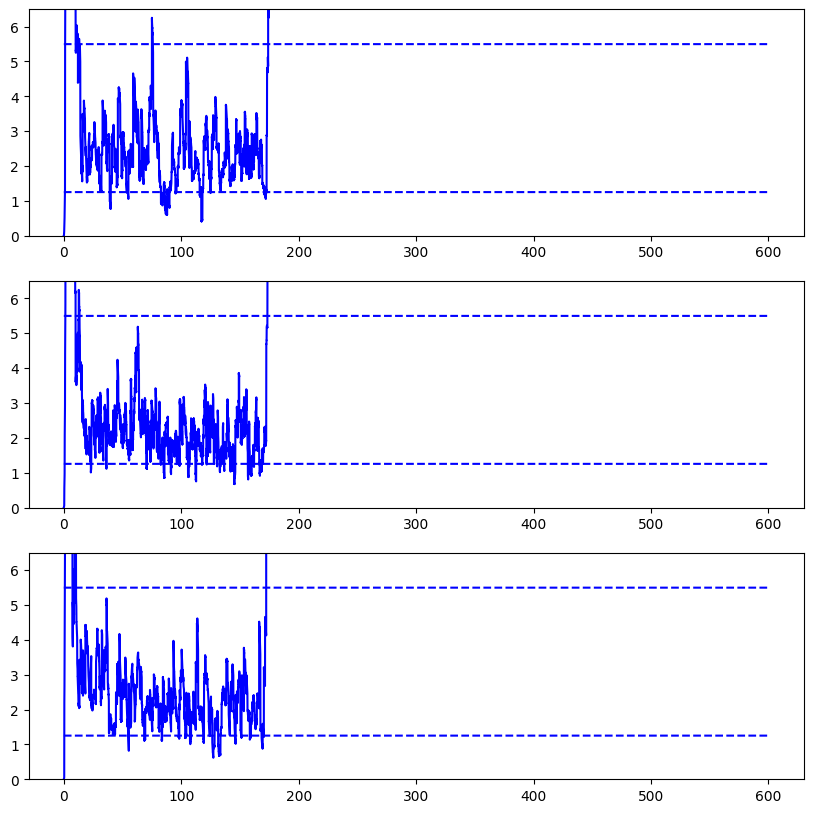

In [5]:
# Plot metrics:
# ANEES analysis
# If higher than confidence interval, then the estimate is overconfident
fig, axs2 = plt.subplots(3, figsize=(10,10))
anees_sel = np.array([[True],[False],[False]])
pos_ind = [0, 2, 3]
rp.plot_ANEES(axs2[0], 
             x_est=x_logL1[pos_ind,:],
             x_true=robotL1.path[:3,:], 
             P=P_logL1[np.ix_(pos_ind, pos_ind)], 
             rad_sel=anees_sel,
             dt=dt,
             prob=0.95)
rp.plot_ANEES(axs2[1], 
             x_est=x_logL2[pos_ind,:],
             x_true=robotL2.path[:3,:], 
             P=P_logL2[np.ix_(pos_ind, pos_ind)], 
             rad_sel=anees_sel,
             dt=dt,
             prob=0.95)
rp.plot_ANEES(axs2[2], 
             x_est=x_logL3[pos_ind,:],
             x_true=robotL3.path[:3,:], 
             P=P_logL3[np.ix_(pos_ind, pos_ind)], 
             rad_sel=anees_sel,
             dt=dt,
             prob=0.95)

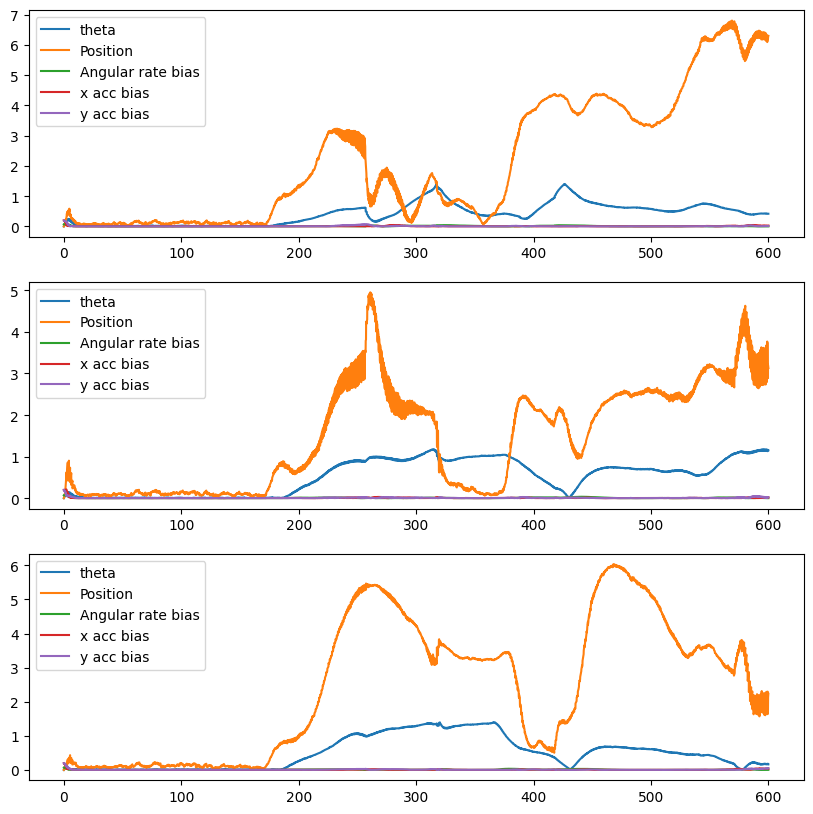

In [10]:
# Plot RMSE errors:
fig, axs3 = plt.subplots(3, figsize=(10,10))

rp.plot_RMSE(axs3[0], x_logL1, robotL1.path, biases=bias_vec, dt=dt)
rp.plot_RMSE(axs3[1], x_logL2, robotL2.path, biases=bias_vec, dt=dt)
rp.plot_RMSE(axs3[2], x_logL3, robotL3.path, biases=bias_vec, dt=dt)

Interesting things to check:
- Anchor placements: If they are very close together, does the estimate then suffer?
- Daisy chain length: If there is a very long chain of drones with only these at the very end having connection to anchors, how does that affect the localization?
- Can a large group still keep consistency?
- What if communication is cut out at various points?
- How long can a group stay consistent, after communication is cut out? and can they recover?
- Outliers! (Important - how does the system handle these?)
- Fast drones with fast turning.
- Lot of orientation shifts (will ML fail?)

TODO:
- Try increasing covariance of measurments, ONLY for relative measurements, to prioritize anchor measurements better
- Dynamic thresholding: Based on the covariance of the bias estimates, decrease the thresholds
- Maximum threshold - just do handtuning

More notes:
- It seems that daisy chains are more susepticle to being thrown off by ML errors - its very dependent on both measurements being correct. If one happens, the system is then having a hard time to recover from it
